In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib
import os
import logging

# --- Configuration ---
# NOTE: When running from a notebook inside backend/notebooks/, the paths need to go up one level.
# Cell 1 (New, Revised)
MODEL_DIR = os.path.join("..", "models") # <-- New directory path
MODEL_PATH = os.path.join(MODEL_DIR, "window_cluster_model.pkl")
SCALER_PATH = os.path.join(MODEL_DIR, "window_scaler.pkl")
MAP_PATH = os.path.join(MODEL_DIR, "cluster_to_appliance_map.pkl")
NUM_CLUSTERS = 3 # We want to find 3 types of green windows

# Set plotting style
sns.set_theme(style="whitegrid")

In [2]:
# Load the historical data from the CSV file
try:
    df = pd.read_csv(DATA_PATH)
    print("Successfully loaded the dataset.")
    print(f"Dataset contains {len(df)} rows.")
except FileNotFoundError:
    print(f"Error: The data file was not found at '{DATA_PATH}'")
    print("Please ensure the 'historical_intensity_data.csv' file exists in the 'backend/data/' directory.")

# Display the first few rows to understand its structure
display(df.head())

# Display data types and check for null values
print("\n--- Dataset Info ---")
df.info()

Successfully loaded the dataset.
Dataset contains 62007 rows.


,from,to,forecast,actual,intensity_index
0,2021-12-31T23:30Z,2022-01-01T00:00Z,83.0,71.0,low
1,2022-01-01T00:00Z,2022-01-01T00:30Z,74.0,74.0,low
2,2022-01-01T00:30Z,2022-01-01T01:00Z,70.0,75.0,low
3,2022-01-01T01:00Z,2022-01-01T01:30Z,70.0,73.0,low
4,2022-01-01T01:30Z,2022-01-01T02:00Z,61.0,68.0,low



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62007 entries, 0 to 62006
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   from             62007 non-null  object 
 1   to               62007 non-null  object 
 2   forecast         61981 non-null  float64
 3   actual           61951 non-null  float64
 4   intensity_index  62007 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.4+ MB


In [4]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies "green windows" and engineers features for them.
    A "green window" is a contiguous block of time where the carbon intensity
    is below the daily average.
    """
    print("Starting feature engineering...")
    
    # 1. Create a clean copy to avoid modifying the original DataFrame
    proc_df = df.copy()
    
    # 2. Convert 'from' column to datetime objects and handle potential errors
    proc_df['from'] = pd.to_datetime(proc_df['from'], errors='coerce')
    proc_df.dropna(subset=['from'], inplace=True) # Drop rows where conversion failed
    proc_df.set_index('from', inplace=True)
    
    # 3. We will train on historical 'actual' intensity. Drop any rows where it's missing.
    proc_df.dropna(subset=['actual'], inplace=True)
    if proc_df.empty:
        raise ValueError("No data with 'actual' intensity values available.")
    print(f"Working with {len(proc_df)} rows after dropping null 'actual' values.")

    # 4. Calculate the rolling 24-hour average intensity (48 half-hour slots)
    proc_df['rolling_avg_24h'] = proc_df['actual'].rolling(window=48, min_periods=1).mean()
    
    # 5. Identify "green" periods (intensity is below the rolling average)
    proc_df['is_green'] = proc_df['actual'] < proc_df['rolling_avg_24h']
    
    # 6. Assign a unique ID to each contiguous block of "green" or "not-green" time
    proc_df['window_id'] = (proc_df['is_green'] != proc_df['is_green'].shift()).cumsum()
    
    green_windows = proc_df[proc_df['is_green']]
    
    if green_windows.empty:
        raise ValueError("No 'green windows' could be identified in the dataset.")
        
    print(f"Identified {green_windows['window_id'].nunique()} potential green windows.")

    # 7. For each window, engineer the features using groupby().agg()
    window_features = green_windows.groupby('window_id').agg(
        duration_mins=('actual', lambda x: len(x) * 30),
        depth_gco2h=('actual', lambda x: x.min() - proc_df.loc[x.index, 'rolling_avg_24h'].mean()),
        
        # --- CORRECTED LOGIC FOR STABILITY ---
        # Calculate standard deviation. The result of this agg will be a Series that may contain NaNs.
        stability_std=('actual', 'std') 
    )
    
    # Now, fill any NaN values in the resulting 'stability_std' column with 0.
    # This correctly handles windows with only one entry.
    window_features['stability_std'].fillna(0, inplace=True)
    
    print("Feature engineering complete.")
    return window_features

# --- Execute the function and display the results ---
features_df = feature_engineering(df)

print(f"\nCreated a feature set with {len(features_df)} windows.")
print("Here are the first few engineered windows:")
display(features_df.head())

Starting feature engineering...
Working with 61951 rows after dropping null 'actual' values.
Identified 1771 potential green windows.
Feature engineering complete.

Created a feature set with 1771 windows.
Here are the first few engineered windows:


/var/folders/5l/_w0625xs2ldb8v6t7h_d5hrh0000gn/T/ipykernel_3617/884219980.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  window_features['stability_std'].fillna(0, inplace=True)


,duration_mins,depth_gco2h,stability_std
window_id,,,
2,690,-18.391255,8.332042
4,30,-2.321429,0.000000
6,600,-15.737234,4.451789
8,660,-25.888258,7.062492
10,450,-27.323611,7.321202


--- Statistical Summary of Engineered Features ---


,duration_mins,depth_gco2h,stability_std
count,1771.000000,1771.000000,1771.000000
mean,523.704122,-32.783654,10.452137
std,494.478382,30.649341,11.293213
min,30.000000,-184.841146,0.000000
25%,150.000000,-48.047619,2.524953
50%,420.000000,-24.408333,7.184087
75%,630.000000,-7.849537,14.086282
max,3090.000000,-0.020833,73.237393


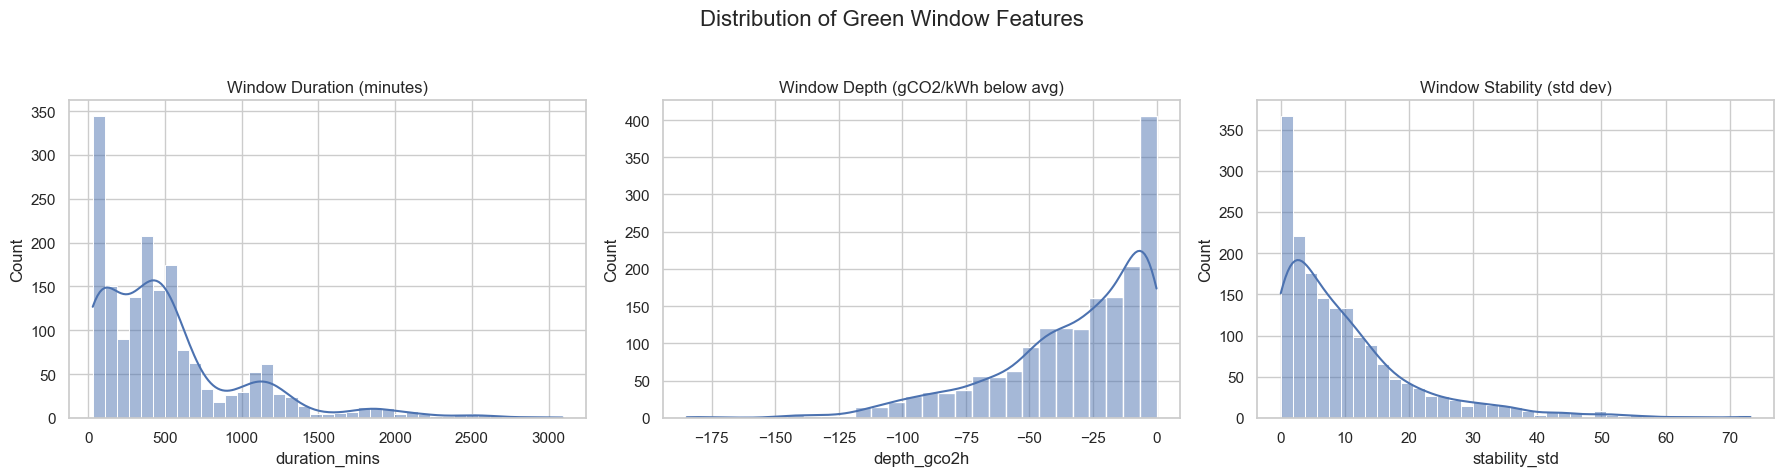

In [5]:
# First, let's get a statistical summary of our new features
print("--- Statistical Summary of Engineered Features ---")
display(features_df.describe())

# Now, let's visualize the distribution of each feature
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Green Window Features', fontsize=16)

# Plot for Duration
sns.histplot(features_df['duration_mins'], ax=axes[0], kde=True)
axes[0].set_title('Window Duration (minutes)')

# Plot for Depth
sns.histplot(features_df['depth_gco2h'], ax=axes[1], kde=True)
axes[1].set_title('Window Depth (gCO2/kWh below avg)')

# Plot for Stability
sns.histplot(features_df['stability_std'], ax=axes[2], kde=True)
axes[2].set_title('Window Stability (std dev)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [6]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to our features and transform them.
# The result is a NumPy array where each feature has a mean of 0 and a standard deviation of 1.
scaled_features = scaler.fit_transform(features_df)

# Initialize the K-Means model
# n_clusters: The number of clusters to find (we configured this as 3)
# random_state: Ensures we get the same results every time we run this. Important for reproducibility.
# n_init='auto': Suppresses a future warning and lets scikit-learn choose the best initialization method.
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto')

# Train the model on the scaled features
kmeans.fit(scaled_features)

# --- Analysis ---
# Add the cluster labels found by the model as a new column in our original features_df.
# This lets us see which cluster each window belongs to.
features_df['cluster'] = kmeans.labels_

print("K-Means training complete.")
print(f"Number of windows in each cluster:")
print(features_df['cluster'].value_counts())

print("\nFirst 5 rows with their assigned cluster:")
display(features_df.head())

K-Means training complete.
Number of windows in each cluster:
cluster
1    983
0    618
2    170
Name: count, dtype: int64

First 5 rows with their assigned cluster:


,duration_mins,depth_gco2h,stability_std,cluster
window_id,,,,
2,690,-18.391255,8.332042,1
4,30,-2.321429,0.000000,1
6,600,-15.737234,4.451789,1
8,660,-25.888258,7.062492,0
10,450,-27.323611,7.321202,1


--- Average Feature Values per Cluster ---


,duration_mins,depth_gco2h,stability_std
cluster,,,
0,719.417476,-48.753954,14.478548
1,225.076297,-11.229341,3.308291
2,1539.000000,-99.361570,37.123182


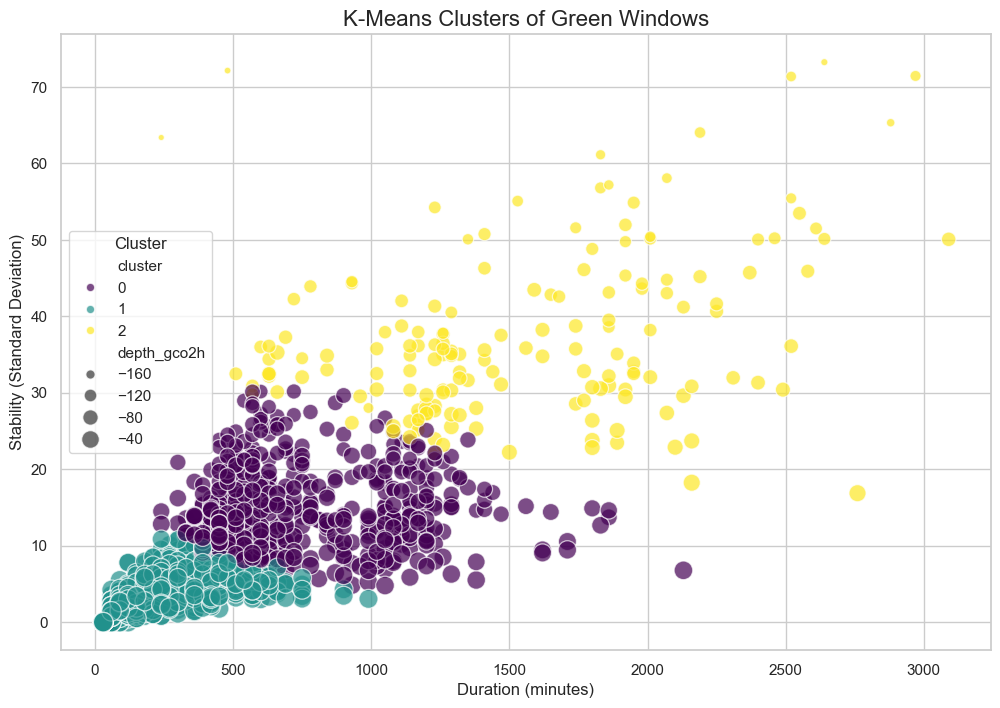

In [7]:
# --- Interpretation ---
# Let's see the average feature values for each cluster.
# This tells us the "personality" of each cluster.
print("--- Average Feature Values per Cluster ---")
cluster_summary = features_df.groupby('cluster').mean()
display(cluster_summary)


# --- Visualization ---
# A 3D scatter plot is perfect for visualizing the three features.
# To make it easier to see, we'll map duration to size and depth to color.

# We use a copy to avoid SettingWithCopyWarning
plot_df = features_df.copy()

# Normalize depth to a 0-1 range for coloring (darker = deeper)
# We subtract the min to make all values positive before normalizing
plot_df['depth_norm'] = (plot_df['depth_gco2h'] - plot_df['depth_gco2h'].min()) / \
                        (plot_df['depth_gco2h'].max() - plot_df['depth_gco2h'].min())


plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_df,
    x='duration_mins',
    y='stability_std',
    hue='cluster',          # Color points by the cluster they belong to
    size='depth_gco2h',     # Make points with deeper (more negative) intensity larger
    sizes=(20, 200),        # Range of point sizes
    palette='viridis',      # A color-blind friendly color palette
    alpha=0.7
)

plt.title('K-Means Clusters of Green Windows', fontsize=16)
plt.xlabel('Duration (minutes)')
plt.ylabel('Stability (Standard Deviation)')
plt.legend(title='Cluster')
plt.show()

In [8]:
# --- Create the "Appliance Map" ---
# Based on our analysis of the cluster summary table.

# We will sort the clusters by their average duration to create a logical order.
# This makes our recommendations more intuitive (e.g., short, medium, long).
sorted_clusters = cluster_summary.sort_values('duration_mins').index.tolist()
print(f"Clusters sorted by duration: {sorted_clusters}")

# Define the profiles for our recommendations
# We map them to the sorted cluster IDs.
appliance_profiles = [
    {
        "name": "Quick Cycle", 
        "reason": "A short, very stable low-carbon window is approaching.",
        "appliance": "Dishwasher" # Matches Cluster 1 (Shortest)
    },
    {
        "name": "Standard Load", 
        "reason": "A long, deep green window is coming up, perfect for a standard cycle.",
        "appliance": "Washing Machine" # Matches Cluster 0 (Medium)
    },
    {
        "name": "EV Charge", 
        "reason": "A very long, extremely green period is available overnight.",
        "appliance": "EV Charger" # Matches Cluster 2 (Longest)
    }
]

# Create the final mapping from the original cluster label to the profile
cluster_to_appliance_map = {}
for i, cluster_id in enumerate(sorted_clusters):
    cluster_to_appliance_map[cluster_id] = appliance_profiles[i]


print("\n--- Generated Cluster-to-Appliance Map ---")
for key, val in cluster_to_appliance_map.items():
    print(f"  Cluster {key} -> '{val['name']}' (recommends: {val['appliance']})")
    
    
# --- Save the Final Artifacts ---
# We use joblib because it's efficient for saving scikit-learn objects (which often contain NumPy arrays).

print(f"\nSaving model to {MODEL_PATH}")
joblib.dump(kmeans, MODEL_PATH)

print(f"Saving scaler to {SCALER_PATH}")
joblib.dump(scaler, SCALER_PATH)

print(f"Saving appliance map to {MAP_PATH}")
joblib.dump(cluster_to_appliance_map, MAP_PATH)

print("\n\n--- MODELING COMPLETE ---")
print("All three artifacts (model, scaler, map) have been saved to the 'backend/' directory.")

Clusters sorted by duration: [1, 0, 2]

--- Generated Cluster-to-Appliance Map ---
  Cluster 1 -> 'Quick Cycle' (recommends: Dishwasher)
  Cluster 0 -> 'Standard Load' (recommends: Washing Machine)
  Cluster 2 -> 'EV Charge' (recommends: EV Charger)

Saving model to ../window_cluster_model.pkl
Saving scaler to ../window_scaler.pkl
Saving appliance map to ../cluster_to_appliance_map.pkl


--- MODELING COMPLETE ---
All three artifacts (model, scaler, map) have been saved to the 'backend/' directory.
